Реализация гамильтониана Изинга для одномерной цепочки атомов: $\hat{H}=J\sum_{i=0}^{N-1}\hat{\sigma}^z_i\hat{\sigma}^z_{i+1} - h\sum^N_{i=0}\hat{\sigma}^z_i$

In [1]:
import numpy as np
from scipy import sparse
from scipy.sparse import linalg as sl

def sigmaz_k(k: int, n: int) -> (sparse.csr_matrix):
    left_part = sparse.eye(2 ** k)
    right_part = sparse.eye(2 ** (n - 1 - k))

    return sparse.kron(
        sparse.kron(
            left_part,
            sparse.csr_matrix(np.array([[1, 0,], [0, -1,],]))
        ),
        right_part
    )

def ising(j: float, h: float, n: int) -> (sparse.csr_matrix): # Ввод константы оменного взаимодействия (J), внешнего поля (h) и числа атомов
    res = sparse.csr_matrix((2 ** n, 2 ** n), dtype=np.complex64)

    for i in range(n - 1):
        res += j * sigmaz_k(i, n) * sigmaz_k(i + 1, n)
        res -= h * sigmaz_k(i, n)
    res -= h * sigmaz_k(n - 1, n)

    return res

In [2]:
op = sparse.csr_matrix(ising(j=1.0, h=2.0, n=10))

1) Выбираем анзатц - оператор B(q) - от будет как-то вращать наше начальное состояние - как именно ещ предстоит разобраться
2) Рандомно генерируем начальные параметры (это черевато, если возможность генерировать их осознано)
3) Обучение градиентным спускомЖ
    1. готовим состояние $|{\Psi}>=B(q_i)|0>$
    2. измеряем $e = <{\Psi}|{A}|{\Psi}>$
    3. вычисляем градиент $g=\frac{\partial e}{\partial  q}$
    4. обновляем параметры $q_{i+1} = q_i - \alpha g $
4) Результат обучения:
    1. Вектор $B(q_n)|0>$ близок к собственному вектору оператора $A$
    2. Соотвествующая этому вектору энергия локально минимальна(близка к собственному значению ${А}$)

In [3]:
import pennylane as qml
from pennylane import numpy as np

N_SPINS = 10
N_LAYERS = 2

device = qml.device("default.qubit", wires=N_SPINS)
ham = qml.SparseHamiltonian(op, wires=list(range(N_SPINS)), id="Hamiltonian") #Что-то с H

def layer(params):
    for i in range(N_SPINS):
        qml.RY(params[i][0], wires=i)
        qml.RZ(params[i][1], wires=i)

    for i in range(N_SPINS - 1):
        qml.CZ(wires=[i, i + 1])

@qml.qnode(device, diff_method="parameter-shift")
def feed_forward(params):
    for k in range(N_LAYERS):
        layer(params[k])

    for i in range(N_SPINS):
        qml.RY(params[-1][i][0], wires=i)
        qml.RZ(params[-1][i][1], wires=i)

    return qml.expval(ham)

"""
params = tuple(
    tuple(
        (
            np.random.rand() * 2 * np.pi,
            np.random.rand() * 2 * np.pi,
        )
        for _ in range(N_SPINS)
    )
    for _ in range(N_LAYERS)
)
"""
par = np.array(tuple(
    tuple(
        (np.random.rand() * 2 *np.pi, np.random.rand() * 2*np.pi)
        for _ in range(N_SPINS)
    )
    for _ in range(N_LAYERS)), requires_grad=True)

print("Result for random weights:" + str(feed_forward(par)))

Result for random weights:4.505394305007126


C:\Users\Anton\AppData\Local\Temp\ipykernel_4100\2986599867.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


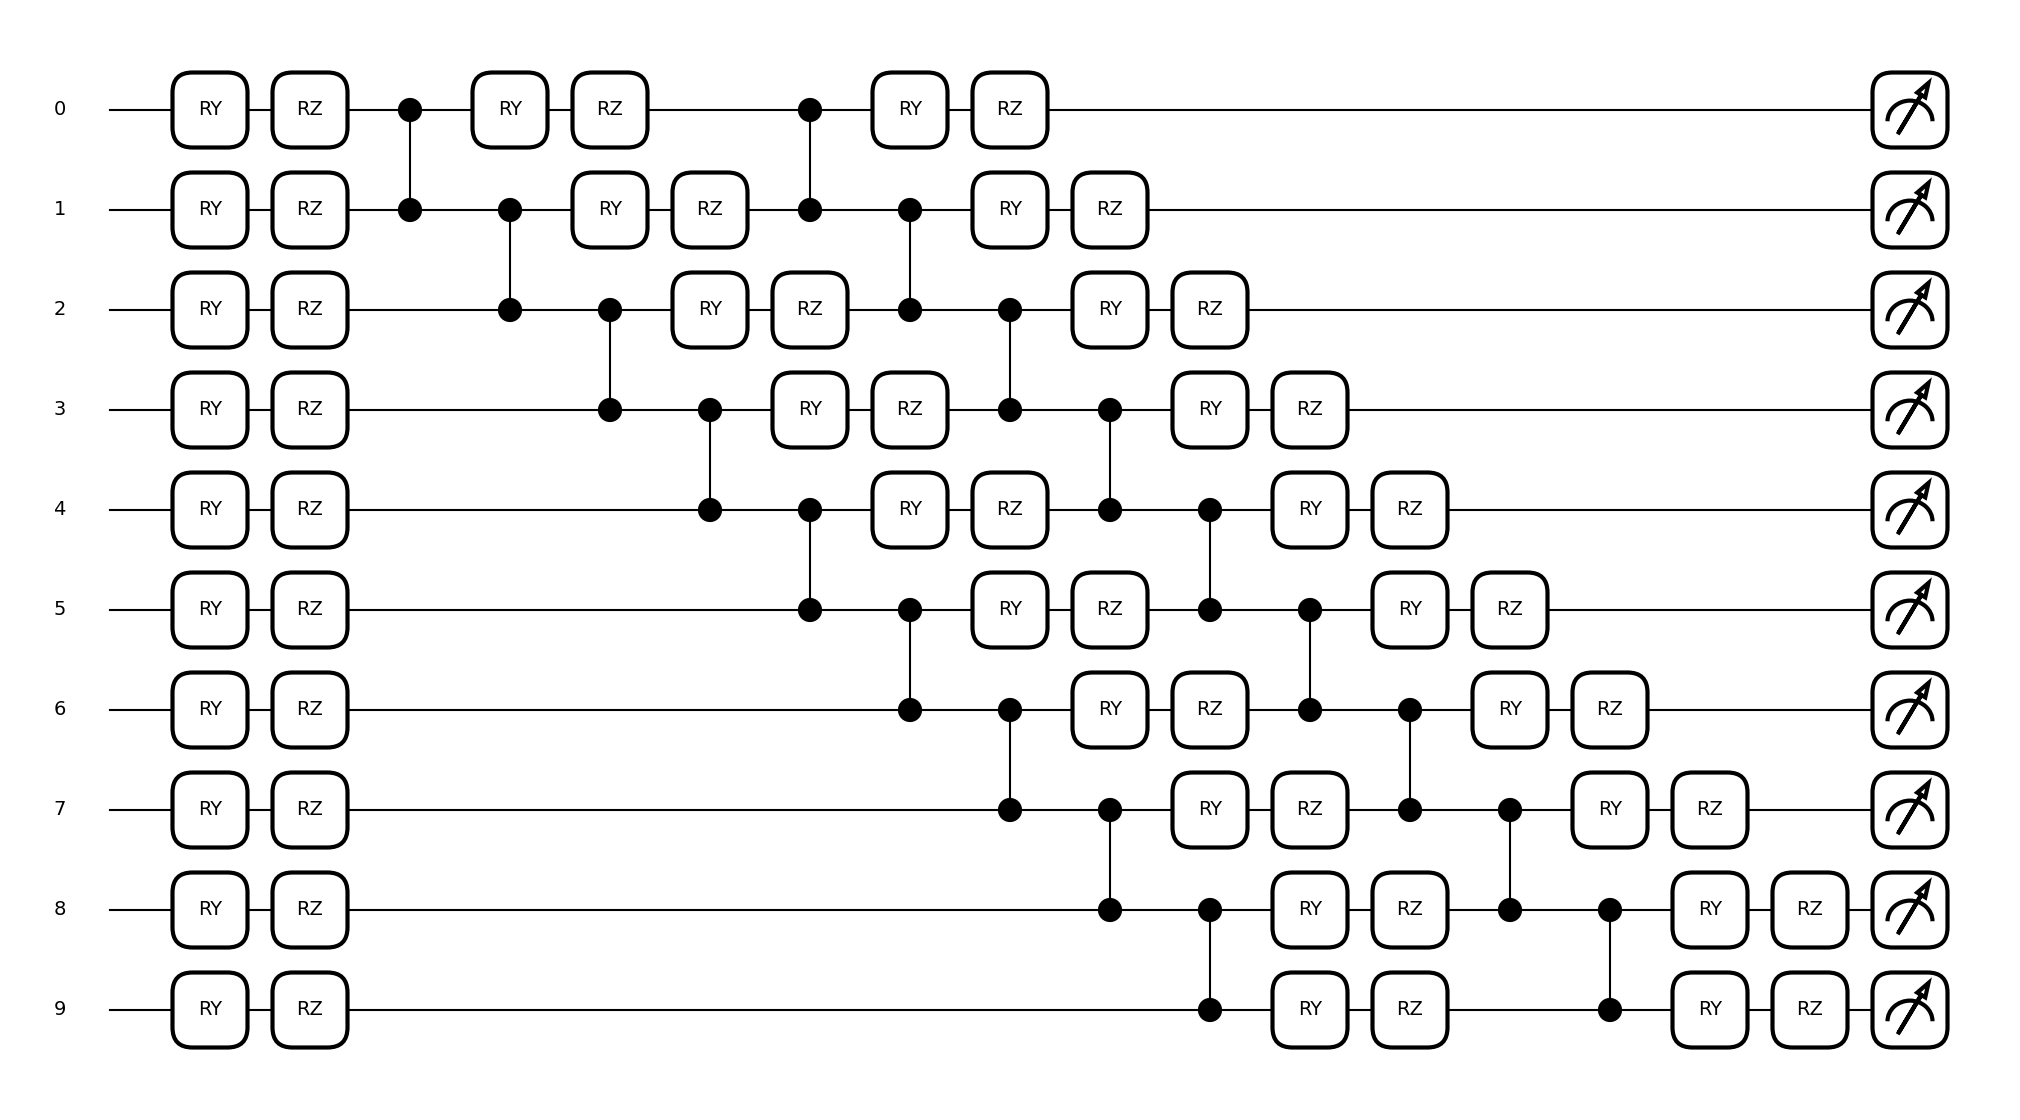

In [4]:
fig, ax = qml.draw_mpl(feed_forward)(par)
fig.show()

In [5]:
exact = -11.0

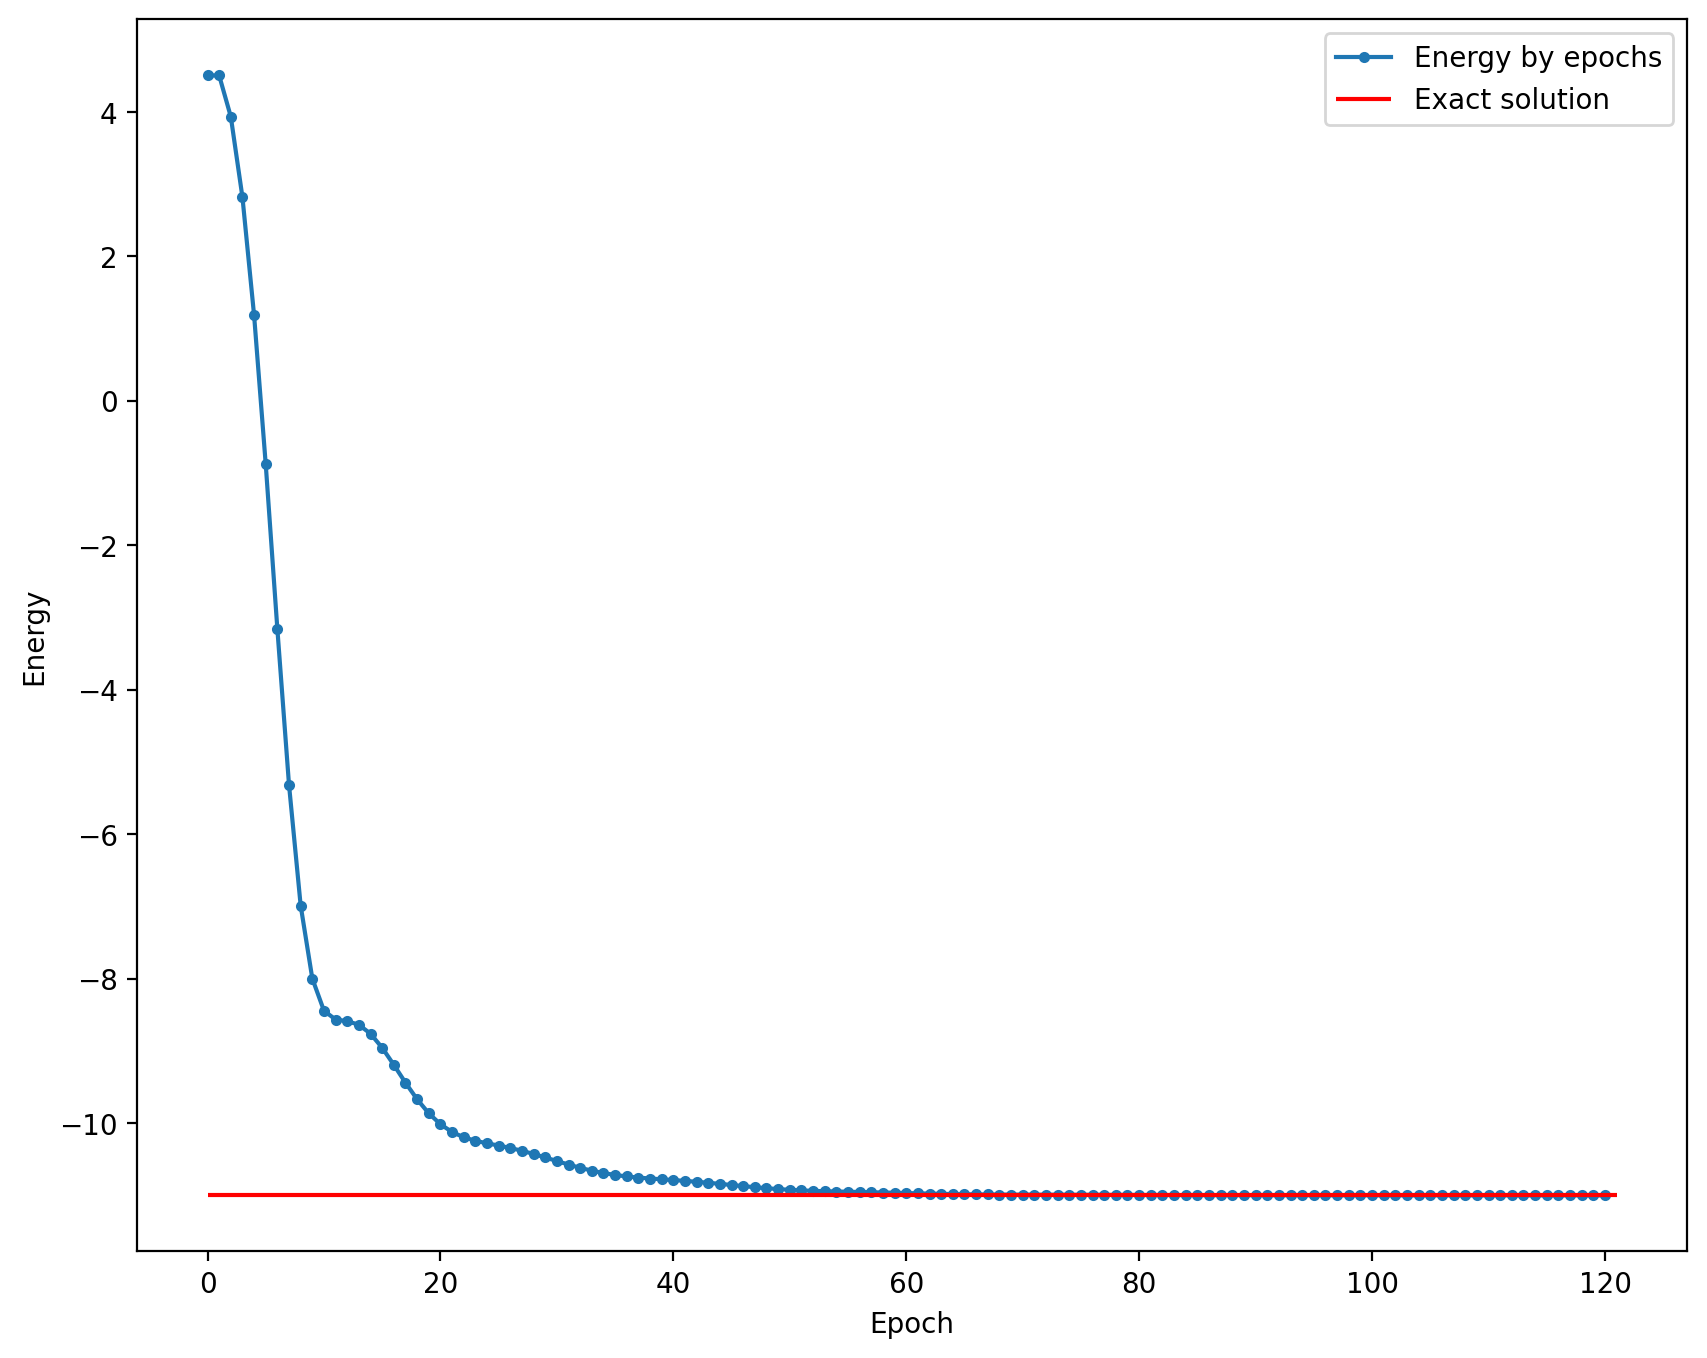

In [6]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "retina"

opt = qml.MomentumOptimizer()

energy = [
    feed_forward(par),
]

for epoch in range(120):
    par, e = opt.step_and_cost(feed_forward, par)
    energy.append(e)

plt.figure(figsize=(10, 8))
plt.plot(np.arange(len(energy)), energy, ".-", label="Energy by epochs")
plt.hlines(
    exact,
    0,
    len(energy),
    color="red",
    label="Exact solution",
)
plt.xlabel("Epoch")
plt.ylabel("Energy")
plt.legend()
plt.show()